## Import modules/scripts and optimize portfolio weights:

In [16]:
from datetime import date, timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import numpy as np
import torch

from JSONReader import read_json
from cov_matrix import MPTCovMat
from optimizer import WeightOptimizer
from backtesting import BackTester

### Set desired parameters

In [17]:
# ---------- OPTIMIZATION ----------
train_start = date(2021,1,1)
train_end = date(2023,12,31)

#loss function:
alpha = 0.2 #calmar
beta = 0.3 #omega
gamma = 0.5 #sortino

#target:
rf = 0.027 #risk free rate (can be used as target rate instead)
rf_period = timedelta(120) #number of days for risk free, e.g. 365 for annual 

num_iter = 40000 #number of weight updates

# ---------- COMPARISON ---------- 
test_start=date(2024,1,1)
test_end=date(2024,10,16 )
comparison_ticker = '^OMX' #ticker of index to compare against


### Optimize weights

In [18]:
ticker_list = read_json('omxs30.json')
tickers = yf.Tickers(ticker_list)

#get data
data = MPTCovMat(tickers=tickers,start=train_start,end=train_end)
returns = data.log_return_df
col_indices = data.col_indices
asset_names = [col_indices[i] for i in sorted(col_indices.keys())]

allocator = WeightOptimizer(lr=1e-3,returns=torch.tensor(returns.values),risk_free=rf,risk_free_period=rf_period,num_iter=num_iter)
cos_losses, pf_returns = allocator.optimize_weights(alpha,beta,gamma)
weights = pd.DataFrame(allocator.alloc_weights.numpy(force=True), index=asset_names, columns=['Weights'])
weights.index.name = 'Ticker'
weights['Weights %'] = weights['Weights']*100
weights['Weights %'].to_csv('weights.csv')
print(weights['Weights %'])

[*********************100%***********************]  30 of 30 completed


Ticker
ABB.ST         4.240422e+01
ALFA.ST        4.806489e-01
ASSA-B.ST      8.141162e-02
ATCO-A.ST      7.432188e-01
ATCO-B.ST      5.567162e-04
AZN.ST         5.400103e-01
BOL.ST         1.454672e-03
ELUX-B.ST      6.233461e-05
ERIC-B.ST      9.091914e-05
ESSITY-B.ST    4.032476e-04
EVO.ST         1.405558e-02
GETI-B.ST      1.395081e-02
HEXA-B.ST      7.386755e-05
HM-B.ST        1.036938e-02
INVE-B.ST      4.037650e+01
KINV-B.ST      1.877753e-07
NDA-SE.ST      1.479790e-01
NIBE-B.ST      1.685929e-03
SAAB-B.ST      1.843859e+00
SAND.ST        1.826704e-06
SBB-B.ST       6.679290e-04
SCA-B.ST       6.906471e-04
SEB-A.ST       1.313803e+01
SHB-A.ST       3.503090e-03
SINCH.ST       7.297492e-04
SKF-B.ST       5.074630e-05
SWED-A.ST      9.856467e-04
TEL2-B.ST      1.090525e-01
TELIA.ST       1.589601e-05
VOLV-B.ST      8.571684e-02
Name: Weights %, dtype: float32


### Plot sharpe ratios to number of iterations

Text(0, 0.5, 'COS Loss')

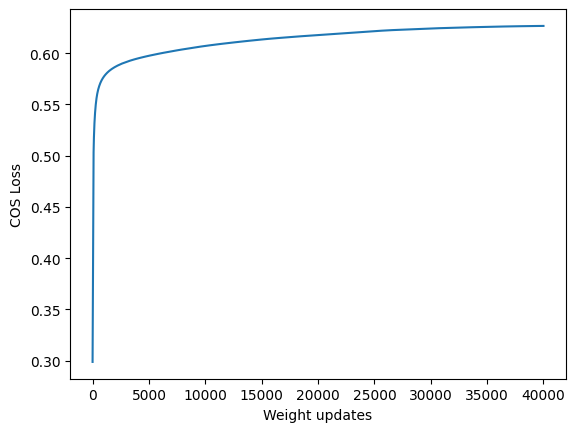

In [19]:
x_df = pd.DataFrame(range(0,num_iter))
plt.plot(x_df,cos_losses.numpy(force=True),)
plt.xlabel('Weight updates')
plt.ylabel('COS Loss')

## Backtesting

### Get comparison data

In [20]:
tester = BackTester(test_weights=pd.DataFrame(weights['Weights']),start=test_start,end=test_end,tickers=tickers)
comp_data = yf.Ticker(comparison_ticker).history(start=test_start,end=test_end,auto_adjust=True)
comp_returns:pd.DataFrame = np.log(comp_data['Close']/comp_data['Close'].shift(1))
comp_returns.dropna(inplace=True)
comp_cumulative = (comp_returns+1).cumprod(0)-1

[*********************100%***********************]  30 of 30 completed


TESTER


### Plot  results

Comparison portfolio return: 6.94 %
Optimized portfolio return: 31.47 %
Percentage point difference: 24.53 pp
Percentage difference: 353.46 %


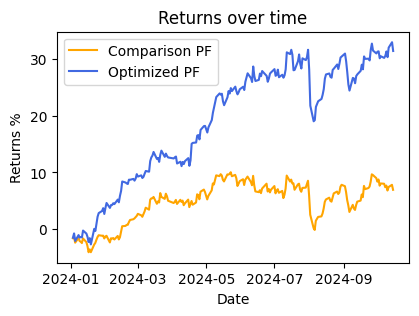

In [21]:
comp_returns = pd.DataFrame(comp_cumulative)
test_returns = tester.cumulative_returns(tester.test_portfolio_returns)
ax1=plt.subplot(1,2,1)
ax1.set_title('Returns over time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Returns %')
ax1.figure.set_size_inches(10,3)
ax1.xaxis.set_major_formatter(mdates.AutoDateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=2,maxticks=8))
ax1.plot(comp_returns.mul(100),color='orange')
ax1.plot(test_returns.mul(100),color='royalblue')
ax1.legend(['Comparison PF','Optimized PF'])
comp_final_return = round((comp_returns.iloc[-1].values*100).item(),2)
optimized_final_return = round((test_returns.iloc[-1,:].values*100).item(),2)
comp_optim_diff = optimized_final_return-comp_final_return
perc_diff = round(((optimized_final_return/comp_final_return)-1)*100,2)

print(f'Comparison portfolio return: {str(comp_final_return)+' %'}')
print(f'Optimized portfolio return: {str(optimized_final_return)+' %'}')
print(f'Percentage point difference: {round(comp_optim_diff,2)} pp')
print(f'Percentage difference: {round(((optimized_final_return/comp_final_return)-1)*100,2)} %')